In [449]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tabulate import tabulate

ECE475 Frequentist Machine Learning <br>
Project 2 - Logistic Regression <br> 
Ali Ghuman, Layth Yassin, Simon Yoon <br>

In this project, we demonstrated logistic regression with stochastic gradient descent as the optimization algorithim, with and without L2 regularization. Firstly, we replicated the 
analysis of the South African heart disease dataset from the Elements of Statistical Learning
textbook and plotted analogously. We then selected the optimal model via forward stepwise via 
cross-validation to ascertain the most significant features. This analysis was duplicated for 
a binary classification dataset of our choice from UCI. We found that he most important features were 
['sbp', 'tobacco', 'ldl', 'famhist', 'age'] 

We repeated this analysis for the stretch goal and found that the most important features were very similar, but with one difference, sbp was replaced with obesity. These results are close enough to indicate that the results are consistent accross different regularization methodologies. 


In [450]:
data = pd.read_csv("./SAheart.csv", sep=",", decimal='.').drop(["adiposity", "typea"],axis=1)

labels = data["chd"].to_numpy()
data = data.drop(["chd"], axis=1)

# Famhist to 0,1's
tmp = data["famhist"].values
tmp = (tmp == "Present") * 1
data["famhist"] = tmp
feature_names = data.columns.values

# Scale data and cast 
data = (data - data.mean()) / data.std()
data.insert(0, "intercept", np.ones(data.shape[0]))
data_numpy = data.to_numpy()

# Split data in training, validation, and test - [0.8, 0.1, 0.1]
x_train, x_test, y_train, y_test = train_test_split(data_numpy, labels, test_size=0.1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=(data.shape[0] * 0.10) / x_train.shape[0])

data.head()

,intercept,sbp,tobacco,ldl,famhist,obesity,alcohol,age
0,1.0,1.057417,1.821099,0.477894,1.184570,-0.176594,3.274189,0.628654
1,1.0,0.276789,-0.789382,-0.159507,-0.842361,0.670646,-0.612081,1.381617
2,1.0,-0.991731,-0.774141,-0.608585,1.184570,0.734723,-0.540597,0.217947
3,1.0,1.545310,0.841352,0.806252,1.184570,1.411091,0.294742,1.039361
4,1.0,-0.211103,2.169453,-0.598928,1.184570,-0.012842,1.645991,0.423301


In [451]:
def sigmoid(x: np.ndarray, theta: np.ndarray) -> np.ndarray:
    x = x.reshape(-1, theta.shape[1])
    return (1 / (1 + np.exp(- (theta @ x.T)))).flatten()

def loss(y, y_hat):     
    return np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

def accuracy(y, y_hat): 
    return ((y_hat > 0.5) == y).mean()

def sgd(epochs, x, y, learning_rate, initial_theta, validation, regularization, L1=0, lamb=None):
    # Stochastic Gradient Descent (SGD) implementation 
    theta = initial_theta
    y_valid = validation[1]
    validation_data = validation[0]

    for i in range(epochs):
        chosen = np.random.randint(y.shape[0])
        x_chosen = x[chosen, :]
        y_chosen = y[chosen]
    
        reg = 0
        for j in range(theta.shape[1]):
            if regularization and L1: 
                reg = lamb * learning_rate * np.sign(theta[0, j])
            elif regularization: # w/ w/o reg 
                reg = 0.001 * theta[0, j]
            theta[0, j] = theta[0, j] + learning_rate * (y_chosen - sigmoid(x_chosen, theta)) * x_chosen[j] - reg

        y_hat = sigmoid(x, theta)
        training_accuracy = accuracy(y, y_hat)
        training_prob = loss(y, y_hat)

        y_val = sigmoid(validation_data, theta)
        validation_accuracy = accuracy(y_valid, y_val)
        validation_prob = loss(y_valid, y_val)

    return theta, validation_accuracy

def display_output(theta, updated_test, y_test, output_string):
    # Function to print accuracy and loss
    y_hat = sigmoid(updated_test, theta)
    los = loss(y_test, y_hat)
    acc = accuracy(y_test, y_hat)
    table = [['Accuracy', acc], ['Loss', los]]
    print(f'{output_string}')
    print(tabulate(table, tablefmt="fancy_grid")) 
    print('\n')

In [452]:
theta = np.zeros([1, x_train.shape[1]])
# SGD
# without L2
theta_out, val_prob = sgd(1000, x_train, y_train, 0.001, theta,
                        (x_valid, y_valid),
                        regularization=False
)
display_output(theta_out, x_test, y_test, "SGD without L2")

# with L2
theta_out_l2, val_prob = sgd(1000, x_train, y_train, 0.001, theta,
                        (x_valid, y_valid),
                        regularization=True
)
display_output(theta_out_l2, x_test, y_test, "SGD with L2")

SGD without L2
╒══════════╤═══════════╕
│ Accuracy │  0.808511 │
├──────────┼───────────┤
│ Loss     │ -0.59215  │
╘══════════╧═══════════╛


SGD with L2
╒══════════╤═══════════╕
│ Accuracy │  0.808511 │
├──────────┼───────────┤
│ Loss     │ -0.604825 │
╘══════════╧═══════════╛




In [453]:
# step-wise analysis of weights
indices = list(range(8))
theta_initial = np.ndarray(shape=(1, 0))
x = np.ndarray(shape=(x_train.shape[0], 0))
val = np.ndarray(shape=(x_valid.shape[0], 0))
test = np.ndarray(shape=(x_test.shape[0], 0))
best_indices = []
features_deleted = np.copy(feature_names)
i = 0
for j in range(5):
    best_prob = float("-inf")
    for i in indices: # unchosen features at indices
        tmp_theta = theta_out[0, i].reshape(1, -1)
        tmp_x = x_train[:, i].reshape(-1, 1)
        tmp_val = x_valid[:, i].reshape(-1, 1)

        theta, prob = sgd(1000, tmp_x, y_train, 0.001,
                            tmp_theta, (tmp_val, y_valid), regularization=False,
        )
        if best_prob < prob:
            best_prob = prob
            best_index = i

    features_deleted[best_index - 1] = '0'
    indices.remove(best_index)
    theta_initial = np.concatenate((theta_initial, theta_out[0, best_index].reshape(1, -1)), axis = 1)
    x = np.concatenate((x, x_train[:, best_index].reshape(-1, 1)), axis = 1)
    val = np.concatenate((val, x_valid[:, best_index].reshape(-1, 1)), axis = 1)
    test = np.concatenate((test, x_test[:, best_index].reshape(-1, 1)), axis = 1)

In [454]:
display_output(theta_initial, test, y_test, "SGD with Step-Wise")

SGD with Step-Wise
╒══════════╤═══════════╕
│ Accuracy │  0.808511 │
├──────────┼───────────┤
│ Loss     │ -0.630492 │
╘══════════╧═══════════╛




In [455]:
best_features = []
for index, val in enumerate(features_deleted): 
    if val == '0': 
        best_features.append(feature_names[index])
best_features

['sbp', 'tobacco', 'ldl', 'famhist', 'age']

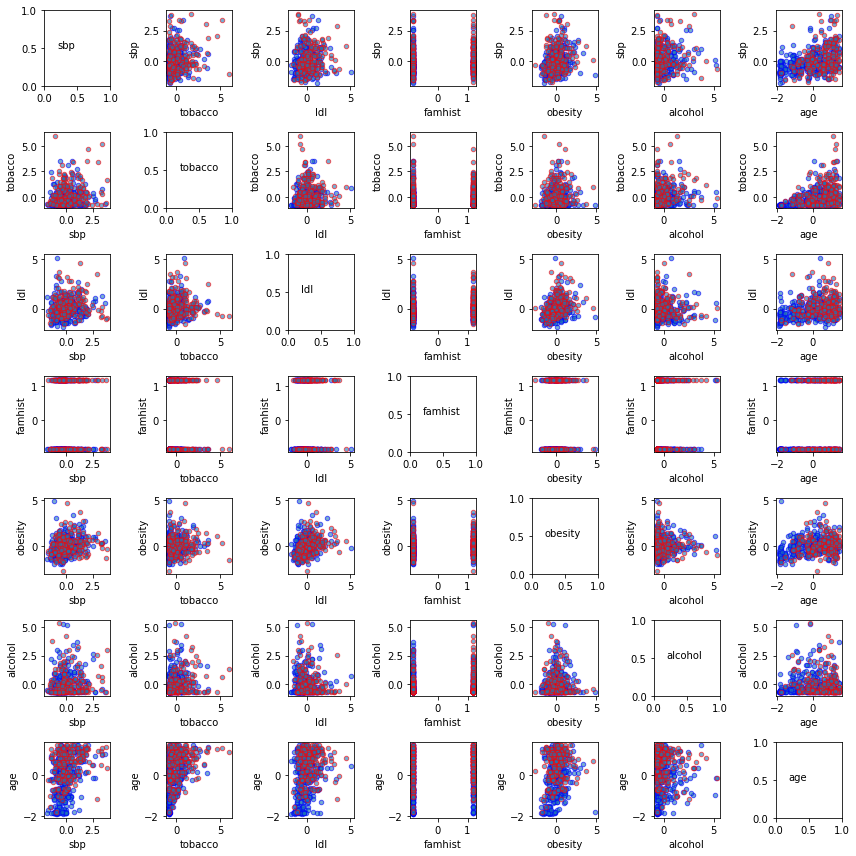

In [456]:
def compile_scatters(data):
    # Function for plotting and combining scatters for SA Dataset
    fig, ax = plt.subplots(7, 7, figsize=(12,12))
    class1 = data[labels == 0]
    class2 = data[labels == 1]

    values = data.columns.values[1:] # to remove first row & col
    for i in range(len(values)):
        for j in range(len(values)):
            if i == j:
                ax[i,i].text(0.2, 0.5, values[i])
                continue
            class1.plot(kind='scatter', x=values[j], y=values[i], ax=ax[i,j],
                        facecolors='none', edgecolors="b", alpha=0.6)
            class2.plot(kind='scatter', x=values[j], y=values[i], ax=ax[i,j],
                        facecolors='none', edgecolors="r", alpha=0.6)
    
    fig.tight_layout()
    plt.show()
compile_scatters(data)

In [457]:
df_cancer = pd.read_csv("./breast-cancer.csv").drop("id", axis=1)
tmp = df_cancer["diagnosis"].values
labels_cancer = (tmp == "M") * 1
df_cancer = df_cancer.drop("diagnosis", axis=1)

feature_names = df_cancer.columns.values

df_cancer = (df_cancer - df_cancer.mean()) / df_cancer.std()
df_cancer.insert(0, "intercept", np.ones(df_cancer.shape[0]))
df_cancer_numpy = df_cancer.to_numpy()

# Split df_cancer in training, validation, and test - [0.8, 0.1, 0.1]
x_train_cancer, x_test_cancer, y_train_cancer, y_test_cancer = train_test_split(df_cancer_numpy, labels_cancer, test_size=0.1)
x_train_cancer, x_valid_cancer, y_train_cancer, y_valid_cancer = train_test_split(x_train_cancer, y_train_cancer, test_size=(df_cancer.shape[0] * 0.10) / x_train_cancer.shape[0])

df_cancer.head()

,intercept,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.0,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,...,1.885031,-1.358098,2.301575,1.999478,1.306537,2.614365,2.107672,2.294058,2.748204,1.935312
1,1.0,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,...,1.804340,-0.368879,1.533776,1.888827,-0.375282,-0.430066,-0.146620,1.086129,-0.243675,0.280943
2,1.0,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,...,1.510541,-0.023953,1.346291,1.455004,0.526944,1.081980,0.854222,1.953282,1.151242,0.201214
3,1.0,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,...,-0.281217,0.133866,-0.249720,-0.549538,3.391291,3.889975,1.987839,2.173873,6.040726,4.930672
4,1.0,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,...,1.297434,-1.465481,1.337363,1.219651,0.220362,-0.313119,0.612640,0.728618,-0.867590,-0.396751


In [458]:
theta = np.zeros([1, x_train_cancer.shape[1]])
# SGD
# without L2
theta_out, val_prob = sgd(1000, x_train_cancer, y_train_cancer, 0.001, theta,
                        (x_valid_cancer, y_valid_cancer),
                        regularization=False
)
display_output(theta_out, x_test_cancer, y_test_cancer, "SGD without L2")

# with L2
theta_out_l2, val_prob = sgd(1000, x_train_cancer, y_train_cancer, 0.001, theta,
                        (x_valid_cancer, y_valid_cancer),
                        regularization=True
)
display_output(theta_out_l2, x_test_cancer, y_test_cancer, "SGD with L2")


SGD without L2
╒══════════╤═══════════╕
│ Accuracy │  0.964912 │
├──────────┼───────────┤
│ Loss     │ -0.242689 │
╘══════════╧═══════════╛


SGD with L2
╒══════════╤═══════════╕
│ Accuracy │  0.964912 │
├──────────┼───────────┤
│ Loss     │ -0.293735 │
╘══════════╧═══════════╛




In [459]:
# step-wise analysis of weights
indices = list(range(8))
theta_initial = np.ndarray(shape=(1, 0))
x = np.ndarray(shape=(x_train_cancer.shape[0], 0))
val = np.ndarray(shape=(x_valid_cancer.shape[0], 0))
test = np.ndarray(shape=(x_test_cancer.shape[0], 0))

for j in range(5):
    best_prob = float("-inf")
    for i in indices: # unchosen features at indices
        tmp_theta = theta_out[0, i].reshape(1, -1)
        tmp_x = x_train_cancer[:, i].reshape(-1, 1)
        tmp_val = x_valid_cancer[:, i].reshape(-1, 1)

        theta, prob = sgd(1000, tmp_x, y_train_cancer, 0.001,
                            tmp_theta, (tmp_val, y_valid_cancer), regularization=False,
        )
        if best_prob < prob:
            best_prob = prob
            best_index = i

    indices.remove(best_index)
    theta_initial = np.concatenate((theta_initial, theta_out[0, best_index].reshape(1, -1)), axis = 1)
    x = np.concatenate((x, x_train_cancer[:, best_index].reshape(-1, 1)), axis = 1)
    val = np.concatenate((val, x_valid_cancer[:, best_index].reshape(-1, 1)), axis = 1)
    test = np.concatenate((test, x_test_cancer[:, best_index].reshape(-1, 1)), axis = 1)

In [460]:
display_output(theta_initial, test, y_test_cancer, "SGD with Step-Wise")

SGD with Step-Wise
╒══════════╤═══════════╕
│ Accuracy │  0.947368 │
├──────────┼───────────┤
│ Loss     │ -0.544043 │
╘══════════╧═══════════╛




In [461]:
#Stretch Goal 
def lasso_model(x, y, labels, learning_rate, validation, theta):
    lambdas = np.linspace(0, 1, 50)

    best_loss = float("-inf")
    best_lam = -1
    thetas = np.zeros((x.shape[1], 50))
    index = 0
    for i, lam in enumerate(lambdas):
        new_theta, val = sgd(1000, x,
                        y, learning_rate, theta,
                        (validation[0], validation[1]),
                        1,L1 = 1, lamb=lam)
        thetas[:, i] = new_theta
        if val > best_loss:
            best_loss = val
            best_lam = lam
            index = i
    return thetas, index

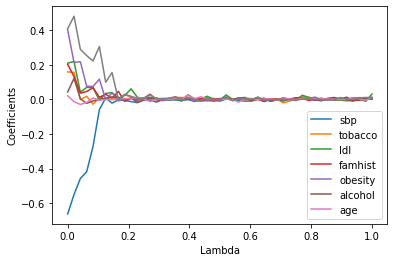

In [462]:
feature_names = data.columns.values
theta = np.zeros([1, x_train.shape[1]])
thetas, index = lasso_model(x_train, y_train, feature_names, 0.01, 
                validation=(x_valid, y_valid), theta=theta
    )
plt.figure()
plt.plot(np.linspace(0, 1, 49), thetas.T[1:, :])
plt.xlabel("Lambda")
plt.ylabel("Coefficients")
plt.legend(feature_names[1:], loc="lower right")
plt.show()

In [463]:
display_output(thetas[:,index].reshape(1, 8), x_test, y_test, "SGD with L1")
best_features = list(zip(thetas[:, index], feature_names))
best_features.sort(key = lambda x: -x[0])
best_features

SGD with L1
╒══════════╤═══════════╕
│ Accuracy │  0.765957 │
├──────────┼───────────┤
│ Loss     │ -0.53551  │
╘══════════╧═══════════╛




[(0.2895892462151649, 'age'),
 (0.2174759964315164, 'famhist'),
 (0.04108533854799716, 'tobacco'),
 (0.03599218232135553, 'ldl'),
 (0.0033370166392594756, 'obesity'),
 (-0.0014688019576205458, 'sbp'),
 (-0.029426383250660746, 'alcohol'),
 (-0.4580193461063528, 'intercept')]